## Initialization

In [1]:
import numpy as np
import pandas as pd
import quandl
import os
import math
import time
import datetime
from statistics import mean
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
from bqplot import pyplot as bplt
import matplotlib.pyplot as plt
%matplotlib inline

## Getting Data From Quandl

In [2]:
df_ = quandl.get('WIKI/GOOGL')

In [3]:
df = df_ # Restart the DataFrame
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-01-24,1184.98,1187.05,1167.40,1171.29,1818182.0,0.0,1.0,1184.98,1187.05,1167.40,1171.29,1818182.0
2018-01-25,1180.71,1185.00,1171.84,1182.14,1398961.0,0.0,1.0,1180.71,1185.00,1171.84,1182.14,1398961.0
2018-01-26,1187.53,1187.56,1168.03,1187.56,1981476.0,0.0,1.0,1187.53,1187.56,1168.03,1187.56,1981476.0
2018-01-29,1188.00,1198.00,1184.06,1186.48,1533931.0,0.0,1.0,1188.00,1198.00,1184.06,1186.48,1533931.0
2018-01-30,1177.72,1187.93,1174.51,1177.37,1792602.0,0.0,1.0,1177.72,1187.93,1174.51,1177.37,1792602.0


## Preprocessing

In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100
df = df[["Adj. Close", "HL_PCT", "PCT_Change", "Adj. Volume"]]

In [5]:
df.tail()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2018-01-24,1171.29,1.345525,-1.155294,1818182.0
2018-01-25,1182.14,0.241934,0.121114,1398961.0
2018-01-26,1187.56,0.000000,0.002526,1981476.0
2018-01-29,1186.48,0.970939,-0.127946,1533931.0
2018-01-30,1177.37,0.896914,-0.029718,1792602.0


In [6]:
forecast_col = 'Adj. Close'
df = df.fillna(-99999)
forecast_out = math.ceil(0.01 * len(df))
df['label'] = df[forecast_col].shift(-forecast_out)
f"Days: {forecast_out}"

'Days: 34'

In [7]:
df.tail()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label
Date,,,,,
2018-01-24,1171.29,1.345525,-1.155294,1818182.0,NaN
2018-01-25,1182.14,0.241934,0.121114,1398961.0,NaN
2018-01-26,1187.56,0.000000,0.002526,1981476.0,NaN
2018-01-29,1186.48,0.970939,-0.127946,1533931.0,NaN
2018-01-30,1177.37,0.896914,-0.029718,1792602.0,NaN


In [8]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df = df.dropna()
y = np.array(df['label'])
len(X), len(y)

(3351, 3351)

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [10]:
models = {
    'SVR': svm.SVR(),
    'SVR_POLY': svm.SVR(kernel='poly'),
    'LinearRegression': LinearRegression(n_jobs=-1)
}

In [11]:
for model, clf in models.items():
    start = time.time()
    clf.fit(X_train, y_train)
    print(
        f'{model}: {round(clf.score(X_test, y_test), 3)}. '
        f'Duration: {round(time.time() - start, 3)}s'
    )

SVR: 0.813. Duration: 0.581s
SVR_POLY: 0.645. Duration: 0.511s
LinearRegression: 0.978. Duration: 0.253s


In [12]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [13]:
clf = LinearRegression()
clf.fit(X_train, y_train)
forecast_set = clf.predict(X_lately)

In [14]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

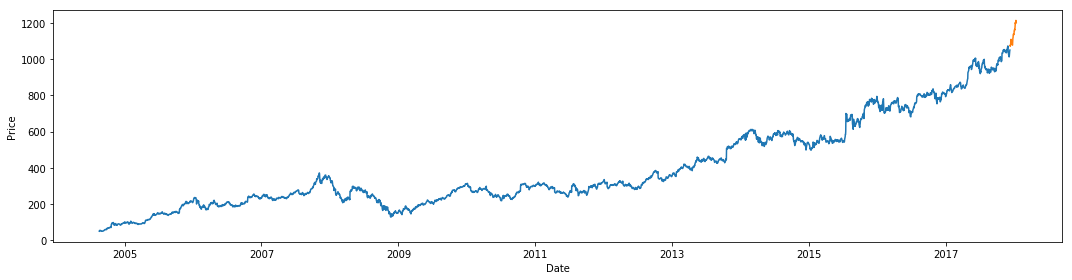

In [15]:
plt.figure(figsize=(15, 4))
plt.plot(df['Adj. Close'])
plt.plot(df['Forecast'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

## Linear Regression Hand Crafted

### Best Fit Line

$$ y = mx + b $$
$$ b = \bar{y} - m\bar{x} $$

$$ and $$

$$ m = \frac{\bar{x}\bar{y}-\bar{xy}}{(\bar{x})^2-\bar{x^2}} $$

$$ or $$

$$ m = \frac{\sum{(x-\bar{x})(y-\bar{y})}}{\sum{(x-\bar{x})^2}} $$

In [16]:
# # 23 µs ± 1.98 µs
# x_mean = xs.mean()
# y_mean = ys.mean()

# # 62 µs ± 935 ns # (xs.mean()*ys.mean() - (xs*ys).mean()) / (xs.mean() ** 2 - (xs ** 2).mean()) 
# # 28.5 µs ± 371 ns # (x_mean*y_mean - (xs*ys).mean()) / (x_mean ** 2 - (xs ** 2).mean())
# # 59.9 µs ± 1.11 µs # ((xs - xs.mean()) * (ys - ys.mean())).sum() / ((xs - xs.mean())**2).sum()
# # 22.5 µs ± 406 ns # ((xs - x_mean) * (ys - y_mean)).sum() / ((xs - x_mean)**2).sum()

In [17]:
import common as cn

In [18]:
cn.create_dataset

<function common.create_dataset>

In [19]:
def create_dataset(number, variance, step=2, correlation=1, offset=(0, 1)):
    x_off, y_off = offset
    xs = np.arange(x_off, number + x_off)
    ys = np.arange(y_off, number*step + y_off, step)
    if correlation == -1:
        ys = ys[::-1]
    ys += np.random.randint(-variance, variance, size=number)
    return xs, ys

In [20]:
def best_fit_slope(xs, ys):
    x_mean = xs.mean()
    y_mean = ys.mean()
    m = ((xs - x_mean) * (ys - y_mean)).sum() / ((xs - x_mean)**2).sum()
    b = y_mean - m * x_mean
    return m, b

In [21]:
def squared_error(y_initial, y_final):
    return ((y_initial - y_final) ** 2).sum()

In [22]:
def coeff_of_determination(y_initial, y_final):
    ser = squared_error(y_initial, y_final)
    sem = squared_error(y_initial, y_initial.mean())
    return 1 - (ser / sem)

In [23]:
def calc_y(x, m=None, b=None):
    if None in [m, b]:
        m, b = best_fit_slope(xs, ys)
    return m * x + b

In [24]:
def add_point(target):
    m, b = best_fit_slope(scat.x, scat.y)
    y_hat.x = scat.x
    y_hat.y = calc_y(scat.x, m, b)

In [25]:
xs, ys = cn.create_dataset(40,20,2, 1, offset=(10,100))
coeff_of_determination(ys, calc_y(xs))

0.809597727712705

In [26]:
bplt.clear() # BQplot code
figure = bplt.figure(title='Regression', animation_duration=500) # BQplot code
scat = bplt.scatter(xs, ys, enable_move=True, interactions={'click': 'add'} )
scat.observe(add_point, names=['x'])
y_hat = bplt.plot(xs, calc_y(xs))
bplt.show()

VBox(children=(Figure(animation_duration=500, axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Scatter(colors=['steelblue'], enable_move=True, interactions={'click': 'add'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]), y=array([ 80, 117,  88,  89, 123,  98, 115, 102, 122,  98, 102, 115, 117,
       132, 136, 111, 136, 129, 146, 136, 157, 140, 152, 158, 128, 156,
       137, 163, 167, 144, 164, 166, 168, 167, 186, 161, 153, 161, 190, 164])), Lines(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, x=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]), y=array([  94.94512195,   97.09409006,   99.24305816,  101.39202627,
        103.54099437,  105.68996248,  107.83893058,  109.98789869,
        112.13686679,  114.2858349 ,  116.434803  ,  118.58377111,
        120.73273921,  122.88170732,  125.03067542,  127.17964353,
        129.32861163,  131.47757974,  133.62654784,  135.77551595,
        137.92448405,  140.07345216,  142.22242026,  144.37138837,
        146.52035647,  148.66932458,  150.81829268,  152.96726079,
        155.11622889,  157.265197  ,  159.4141651 ,  161.56313321,
        163.71210131,  165.86106942,  168.01003752,  170.15900563,
        172.30797373,  174.45694184,  176.60590994,  178.75487805]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Regression'), Toolbar(figure=Figure(animation_duration=500, axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Scatter(colors=['steelblue'], enable_move=True, interactions={'click': 'add'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]), y=array([ 80, 117,  88,  89, 123,  98, 115, 102, 122,  98, 102, 115, 117,
       132, 136, 111, 136, 129, 146, 136, 157, 140, 152, 158, 128, 156,
       137, 163, 167, 144, 164, 166, 168, 167, 186, 161, 153, 161, 190, 164])), Lines(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, 